In [1]:
# import modules
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
warnings.filterwarnings('ignore')

## Data Precprocessing 

In [2]:
# assign path
path, dirs, files = next(os.walk('../data/csv'))
file_count = len(files)

# create empty list
dataframes_list = []
# append datasets to the list 
for i in range(file_count):
    temp_df = pd.read_csv(path+'/'+files[i])
    temp_df = temp_df.drop(columns='year')
    
    # Assign a unique pollutant number to each dataset
    # The value of 'i+1' ensures that each dataset is assigned a unique number starting from 1
    temp_df.insert(2, 'Pollutant', i+1) # 
    dataframes_list.append(temp_df)

# Concatenate dataframes into one signle dataframe
df = pd.concat(dataframes_list, ignore_index= True)    

In [3]:
# Standardizing Data
scaler = StandardScaler()

# Apply StandardScaler to each column except the third one (index 2)
for col in df.columns:
    if df.columns.get_loc(col) != 2:  # Checks if the column index is not 2
        df[col] = scaler.fit_transform(df[[col]])   

## Data Exploration & Visualization

In [4]:
df.isnull().sum()

x            0
y            0
Pollutant    0
conct        0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29282140 entries, 0 to 29282139
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   x          float64
 1   y          float64
 2   Pollutant  int64  
 3   conct      float64
dtypes: float64(3), int64(1)
memory usage: 893.6 MB


In [6]:
df.describe()

,x,y,Pollutant,conct
count,2.928214e+07,2.928214e+07,2.928214e+07,2.928214e+07
mean,3.704553e-15,-1.224374e-16,3.000000e+00,-1.643136e-16
std,1.000000e+00,1.000000e+00,1.414214e+00,1.000000e+00
min,-1.878738e+00,-2.028950e+00,1.000000e+00,-1.123693e+00
25%,-8.421617e-01,-8.240802e-01,2.000000e+00,-6.046423e-01
50%,-3.992524e-03,3.078914e-02,3.000000e+00,-1.303285e-01
75%,8.341766e-01,8.391981e-01,4.000000e+00,3.145508e-01
max,2.205481e+00,1.927918e+00,5.000000e+00,5.150201e+02


9.786051630356388


<Axes: >

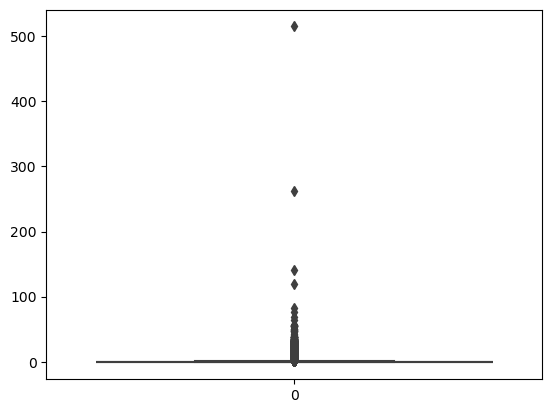

In [7]:
# Check skewness
print(df['conct'].skew())

# Gain insight into data and outliers (Compare mean vs. max)
df.describe()[['conct']]
sns.boxplot(df['conct'])

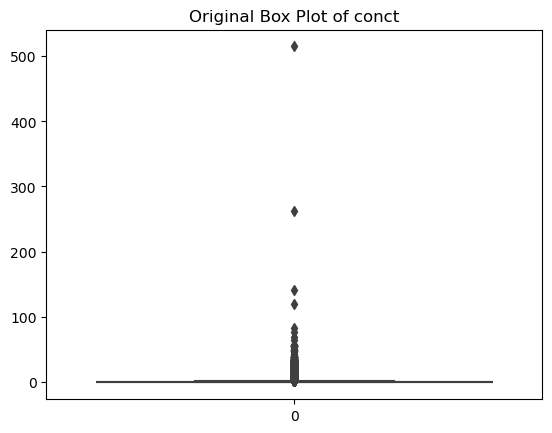

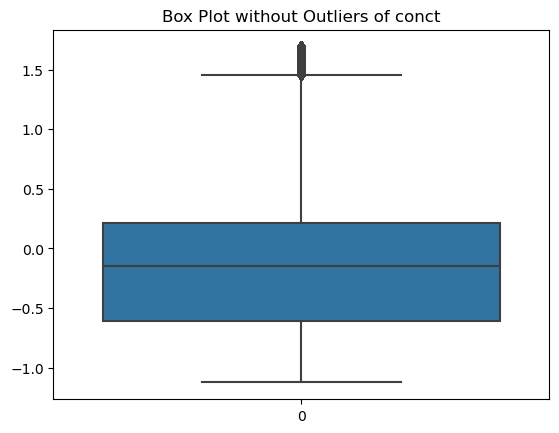

In [8]:
# Function to remove outliers from a specified column using the IQR method
def remove_outliers(df, column):
    # Display the original data distribution in a box plot for visual inspection
    sns.boxplot(df[column])
    plt.title(f'Original Box Plot of {column}')
    plt.show()
    
    # Calculate the IQR which is the difference between 75th and 25th percentiles
    for x in [column]:
        q75,q25 = np.percentile(df.loc[:,x],[75,25])
        intr_qr = q75-q25
        
        # Define the upper and lower bounds for outliers
        max = q75+(1.5*intr_qr)
        min = q25-(1.5*intr_qr)
    
        # Replace outliers with NaN for later removal
        df.loc[df[x] < min,x] = np.nan
        df.loc[df[x] > max,x] = np.nan
        
    # Remove rows with NaN values in the column to clear out the outliers
    df[column].isnull().sum()
    df = df.dropna()
    
    # Display a box plot of the data column after removing outliers
    sns.boxplot(df[column])
    plt.title(f'Box Plot without Outliers of {column}')
    plt.show()
    
    # Return the dataframe with outliers removed
    return df

# Remove outliers from the 'conct' column, presenting many outliers 
df = remove_outliers(df, 'conct')

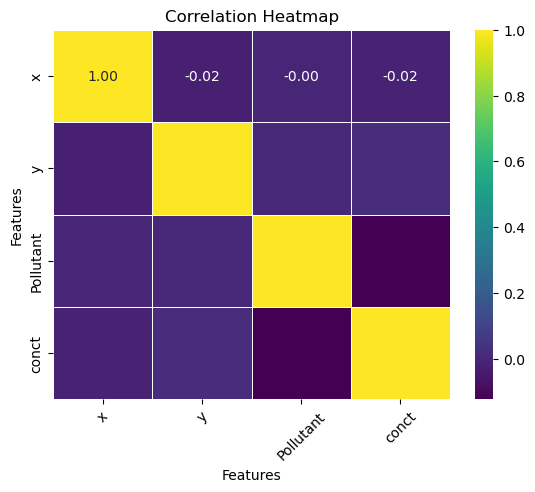

In [9]:
''' Generate and display a heatmap of the correlation matrix for dataframe columns 
to visually inspect the pairwise correlations between features'''
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot = True, cmap = 'viridis', 
            fmt = '0.2f', linewidth = 0.5)
plt.title('Correlation Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')
plt.xticks(rotation = 45)
plt.show()

[Text(0.5, 1.0, 'Concentrations Histogram')]

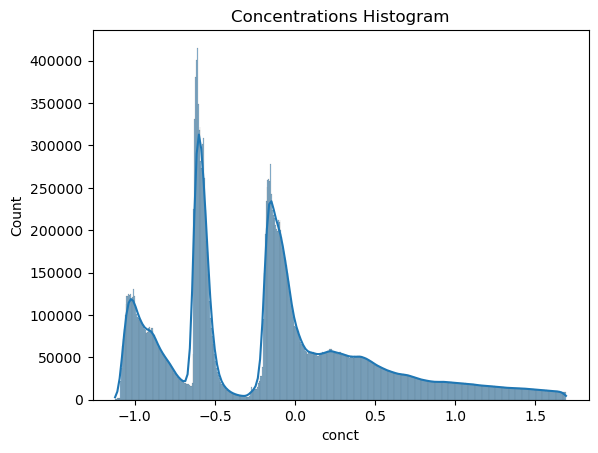

In [10]:
# Plotting Histogram (kde = kernel density)
sns.histplot(df['conct'], kde=True).set(title='Concentrations Histogram')

In [9]:
''' Create a 3D scatter plot to visualize the relationships between the 'x', 'y', 
and 'conct' variables in the dataset '''
fig = plt.figure(figsize = (20,20))
plt.style.use('classic')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x'], df['y'],df['conct'], c = 'red')
ax.set_xlabel('x', fontsize = 20)
ax.set_ylabel('y', fontsize = 20)
ax.set_zlabel('conct', fontsize = 20)

"# 3D visulaisation\nfig = plt.figure(figsize = (20,20))\nplt.style.use('classic')\nax = fig.add_subplot(111, projection='3d')\nax.scatter(df['x'], df['y'],df['conct'], c = 'red')\nax.set_xlabel('x', fontsize = 20)\nax.set_ylabel('y', fontsize = 20)\nax.set_zlabel('conct', fontsize = 20)"

## Regression Models

In [10]:
X = df.drop(columns='conct').values  #features
y = df['conct']  # Target variable

In [11]:
# using the train test split function 
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=104, test_size=0.25, shuffle=True) 

In [12]:
# Function to evaluate the performance of regression models
def evaluate(model, X_train, X_test, y_train, y_test):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

# Evaluation metrics
    print('TRAINING RESULTS FOR {model}: \n===============================')
    print(f'Mean Absolute Error (MAE) - Training: {mean_absolute_error(y_train, y_train_pred):.4f}')
    print(f'Mean Squared Error (MSE) - Training: {mean_squared_error(y_train, y_train_pred):.4f}')
    print(f'R-squared (R²) Score - Training: {r2_score(y_train, y_train_pred):.4f}')

    print('\nTESTING RESULTS FOR {model}: \n===============================')
    print(f'Mean Absolute Error (MAE) - Testing: {mean_absolute_error(y_test, y_test_pred):.4f}')
    print(f'Mean Squared Error (MSE) - Testing: {mean_squared_error(y_test, y_test_pred):.4f}')
    print(f'R-squared (R²) Score - Testing: {r2_score(y_test, y_test_pred):.4f}')

# Predicted vs Actual Density Plot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x=y_test, y=y_test_pred, cmap="Reds", fill=True)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Density Plot of Actual vs Predicted Values')
    plt.show()

# Residuals Hexbin Plot
    residuals = y_test - y_test_pred
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x=y_test_pred, y=residuals, cmap="Purples", fill=True)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Density Residual Plot')
    plt.show()

#### ** Model 1: Decision Tree

TRAINING RESULTS FOR {model}: 
Mean Absolute Error (MAE) - Training: 0.0000
Mean Squared Error (MSE) - Training: 0.0000
R-squared (R²) Score - Training: 1.0000

TESTING RESULTS FOR {model}: 
Mean Absolute Error (MAE) - Testing: 0.0221
Mean Squared Error (MSE) - Testing: 0.0072
R-squared (R²) Score - Testing: 0.9818


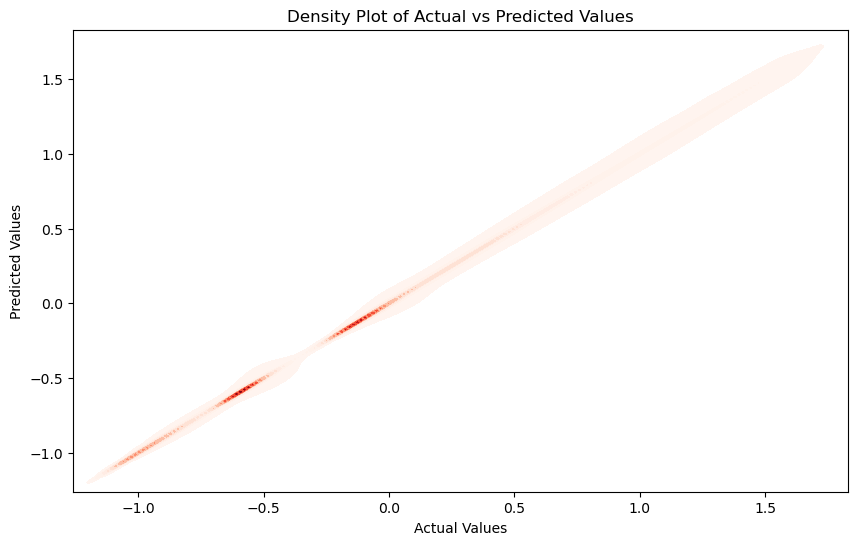

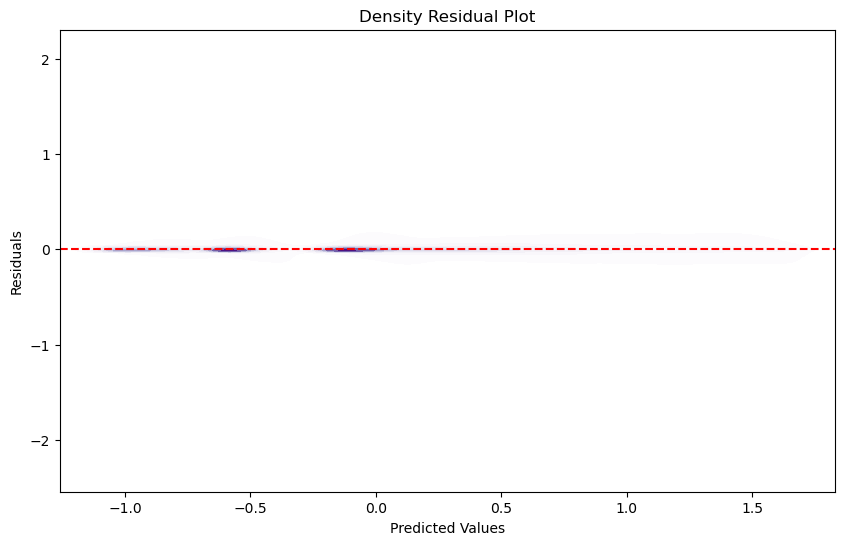

In [13]:
# Train the model on the training dataset
model1 =DecisionTreeRegressor()
model1.fit(X_train, y_train)

# Predict the results for unseen data using the trained model and evaluate performance
evaluate(model1, X_train, X_test, y_train, y_test)

### Ensemble Methods

#### Model 2: KNN Regressor

In [ ]:
# Train the  K-NN model on the training dataset
model2 = KNeighborsRegressor(n_neighbors=3)
model2.fit(X_train, y_train)
# Predicting the Test set results
predictions = model2.predict(X_test)

# Find optimum number of k
rmse_val = []
for k in range(1, 10):
    model2 = KNeighborsRegressor(n_neighbors=k)
    model2.fit(X_train, y_train)
    error = sqrt(mean_squared_error(y_test, predictions)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print(f'Score for k={k}: {model2.score(X_test, y_test)}')

# Print elbow
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

# Predict the results for unseen data using the trained model and evaluate performance
evaluate(model2, X_train, X_test, y_train, y_test )

#### Model 3: Random Forest Reggressor

In [ ]:
# Train the Random Forest Regressor model on the training dataset
model3 = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)
model3.fit(X_train, y_train)

# Predict the results for unseen data using the trained model and evaluate performance
evaluate(model3, X_train, X_test, y_train, y_test)

#### Model 4: BaggingRegressor

In [ ]:
# Create a DecisionTreeRegressor as the base estimator
tree = DecisionTreeRegressor()
# Create a BaggingRegressor ensemble model using DecisionTreeRegressor as the base estimator
model4 = BaggingRegressor(base_estimator=tree, n_estimators=10, random_state=42)
# Train the Bagging Regressor model on the training dataset
model4.fit(X_train, y_train)

# Predict the results for unseen data using the trained model and evaluate performance
evaluate(model4, X_train, X_test, y_train, y_test)